## LINEAR REGRESSION AND EDA BUSINESS CASE STUDY

## Problem Statement:
### An educational platform recently launched a feature where students/learners can come to their website and check their probability of getting into the IVY league college. This feature estimates the chances of graduate admission from an Indian perspective. 
### Our analysis will help the platform in understanding what factors are important in graduate admissions and how these factors are interrelated among themselves. It will also help predict one's chances of admission given the rest of the variables.

### Structure of Notebook:
1. Exploratory Data Analysis: Understanding the data identifying shape and data types along with Univariate and Bivariate analysis
2. Data Preprocessing: Feature Engineering, Encoding and Scaling
3. Model Building: 
>- Check for multicollinearity using VIF
>- Linear Regression Model
>- Linear Regression Model with RFE (Recursive Feature Elimination)
>- Ridge and Lasso Regression Models
>- Compare performance of above models
4. Test assumptions of Linear Regression on the final model
5. Model Performance Evaluation
6. Actionable Insights and Recomendations

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, scale
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import f_oneway

## 1. Exploratory Data Analysis

In [3]:
# read csv file
df = pd.read_csv(r"C:\KT Personal\Data Science\Scaler\Projects\7.Linear Regression\Admission.txt")
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


### Column Profiling:
1. Serial No. - Unique row ID   
2. GRE Scores - out of 340    
3. TOEFL Scores - out of 120  
4. University Rating - out of 5  
5. Statement of Purpose (SOP)- out of 5.   
6. Letter of Recommendation Strength (LOR) - out of 5  
7. Undergraduate GPA - out of 10  
8. Research Experience - either 0 or 1  
9. Chance of Admit - ranging from 0 to 1  

In [3]:
df.shape

(500, 9)

>- Data has information of 500 students. Dataset is small
>- **Dataset contains 8 independent variables and 1 target variable, i.e. Chance of Admit**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


### Insights:
>- As **Serial No.** is only a uniqure row identifier, we do not need it for model building and **can be dropped**
>- All the features are of numerical type originally
>- **University Rating, SOP, LOR and Research experience** are supposed to be categorical variables, **they can be converted to 'category' type**

In [4]:
# Dropping Serial No.
df.drop('Serial No.', axis = 1, inplace = True)

In [5]:
# converting above mentioned columns to category type
cat_cols = ['University Rating', 'SOP', 'LOR ','Research']

df[cat_cols] = df[cat_cols].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   GRE Score          500 non-null    int64   
 1   TOEFL Score        500 non-null    int64   
 2   University Rating  500 non-null    category
 3   SOP                500 non-null    category
 4   LOR                500 non-null    category
 5   CGPA               500 non-null    float64 
 6   Research           500 non-null    category
 7   Chance of Admit    500 non-null    float64 
dtypes: category(4), float64(2), int64(2)
memory usage: 18.8 KB


>- Serial No. dropped and relevant features converted to category type
>- Now the dataset has **7 independent variables and 1 target/dependent variable**

In [7]:
# Checking for missing values

df.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

>- **No missing values found**

In [8]:
# statistical summary of numerical data

df.describe(include = [np.number])

,GRE Score,TOEFL Score,CGPA,Chance of Admit
count,500.000000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,8.576440,0.72174
std,11.295148,6.081868,0.604813,0.14114
min,290.000000,92.000000,6.800000,0.34000
25%,308.000000,103.000000,8.127500,0.63000
50%,317.000000,107.000000,8.560000,0.72000
75%,325.000000,112.000000,9.040000,0.82000
max,340.000000,120.000000,9.920000,0.97000


### Insights:
>- Mean and median for all the 4 variables are almost same hinting at no outliers

In [9]:
df.describe(include = 'category')

,University Rating,SOP,LOR,Research
count,500,500.0,500.0,500
unique,5,9.0,9.0,2
top,3,4.0,3.0,1
freq,162,89.0,99.0,280


### Insights:
>- SOP and LOR have 9 unique values each
>- Research is a binary variable with values either 0 or 1
>- University Rating has 5 unique values

In [6]:
#As some column names have extra spaces, they can be stripped

cols = df.columns
cols = [col.strip() for col in cols]
df.columns = cols


<AxesSubplot:ylabel='Chance of Admit'>

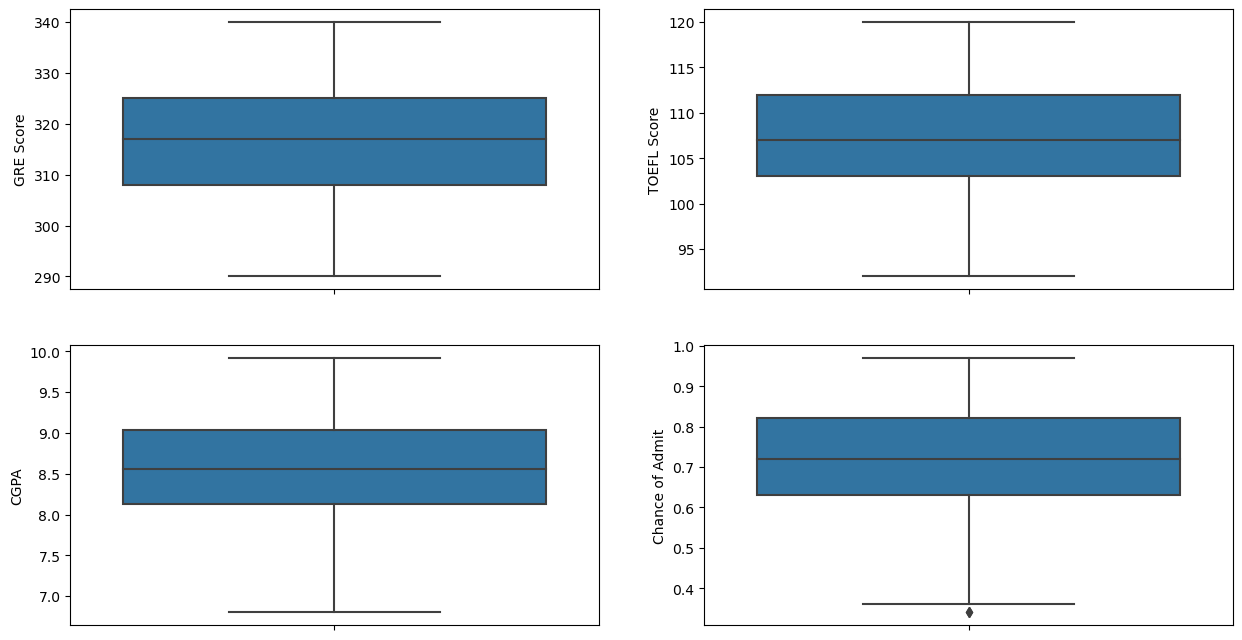

In [11]:
#checking for outliers in numerical data using boxplot

plt.figure(figsize= [15,8])

plt.subplot(2,2,1)
sns.boxplot(y = 'GRE Score', data = df)

plt.subplot(2,2,2)
sns.boxplot(y = 'TOEFL Score', data = df)

plt.subplot(2,2,3)
sns.boxplot(y = 'CGPA', data = df)

plt.subplot(2,2,4)
sns.boxplot(y = 'Chance of Admit', data = df)

### Insights:
>- No presence of outliers seen in independent variables GRE Score, TOEFL Score and CGPA
>- Outliers can be seen in target variable Chance of Admit.

In [12]:
#check outliers in Chance of Admit using IQR method

q1 = df['Chance of Admit'].quantile(0.25)
q3 = df['Chance of Admit'].quantile(0.75)
iqr = q3-q1
outliers = df.loc[(df['Chance of Admit'] < (q1 - 1.5*iqr)) | (df['Chance of Admit']> (q3 + 1.5*iqr))]
outliers

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
92,298,98,2,4.0,3.0,8.03,0,0.34
376,297,96,2,2.5,2.0,7.43,0,0.34


>- Only 2 rows found as outliers in Chance of Admit and can be ignored as it is the target variable

### Univariate Analysis:

In [13]:
# function for univariate analysis of numerical variables and categorical variables

def numerical_uni(col):
    plt.figure(figsize=[15,5])
    plt.subplot(1,2,1)
    sns.histplot(x = df[col], kde= True)

    plt.subplot(1,2,2)
    sns.histplot(x = df[col], stat = 'percent', cumulative= True)

def categorical_uni(col):
    sns.countplot(x = col, data = df)
    percent = df[col].value_counts(normalize = True, sort= False).to_frame().rename({col:'Percentage'}, axis = 1)
    return percent*100

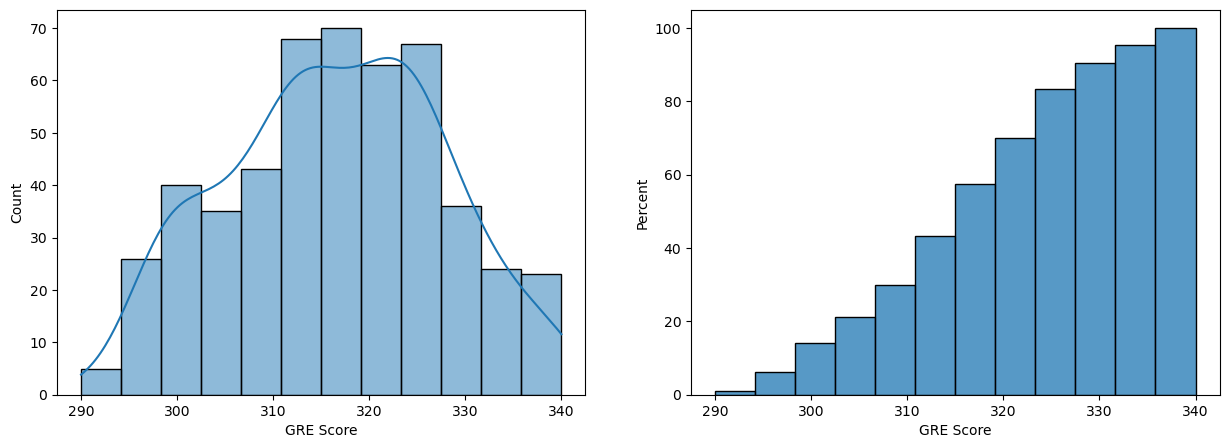

In [14]:
# GRE Score
numerical_uni('GRE Score')

### Insights:
>- Most values of GRE Score concentrated between 310 and 325 aproxiamtely out of 340
>- Almost 60% of the students got scores below 320 and almost 80% below 325 out of 340
>- Only 20* students got scores below 205 approximately out of 340

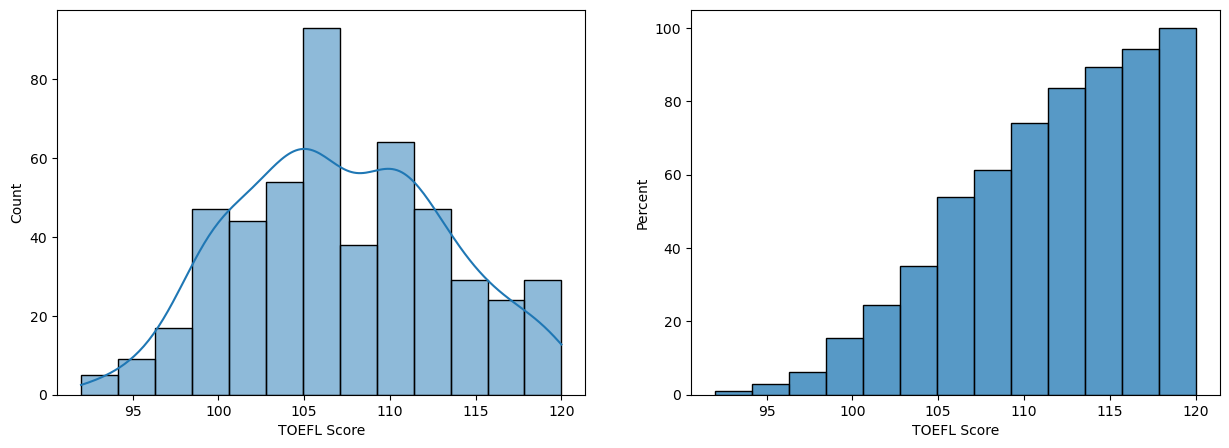

In [15]:
# TOEFL Score
numerical_uni('TOEFL Score')

### Insights:
>- Most students got scores between 100 and 112 approx out of 120
>- Almost 60% of the students got score below 110 and 80% below 112 out of 120
>- Only 20% students got score below 100 out of 120

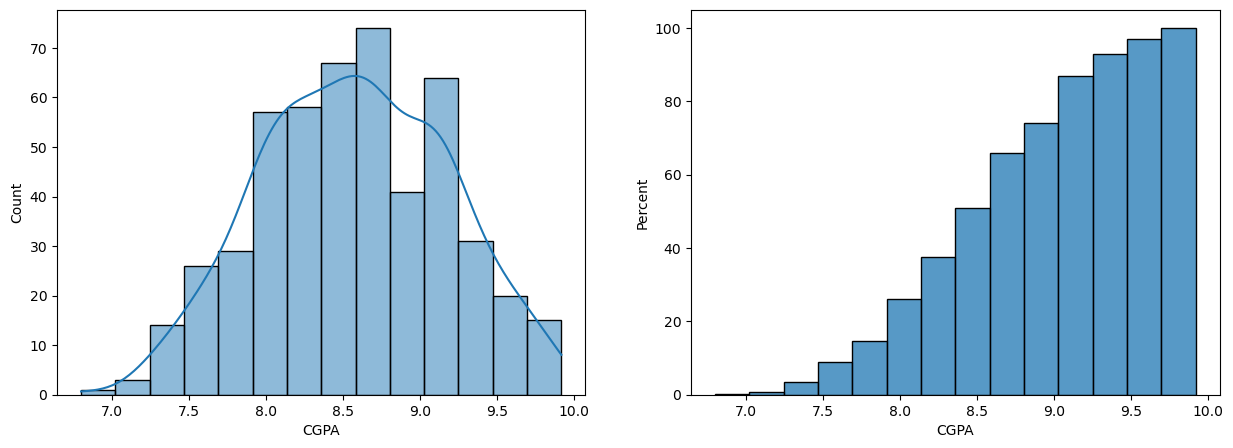

In [16]:
# CGPA
numerical_uni('CGPA')

### Insights:
>- Most students received CGPA between 8 and 9.25 out of 10
>- 60% of students got CGPA below 8.75 and 8% below 9.25 out of 10


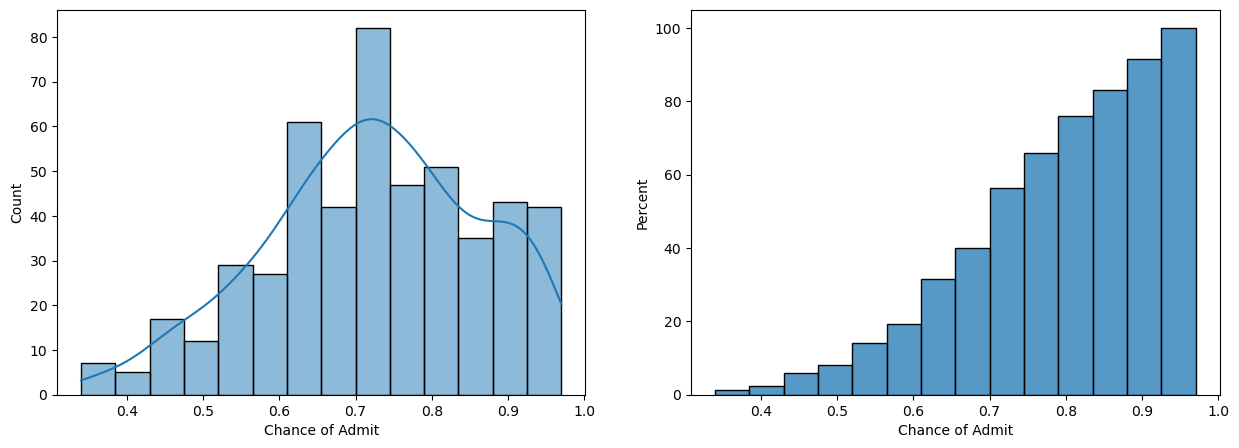

In [17]:
# Chance of Admit
numerical_uni('Chance of Admit')

### Insights:
>- Almost 20% of the students fell in the lower scores up to 0.6 out of 1
>- Almost 60% of students in dataset got higher scores of 0.7 or above
>- Most values lie in the range of 0.6 and 0.85 approx

,Percentage
1,6.8
2,25.2
3,32.4
4,21.0
5,14.6


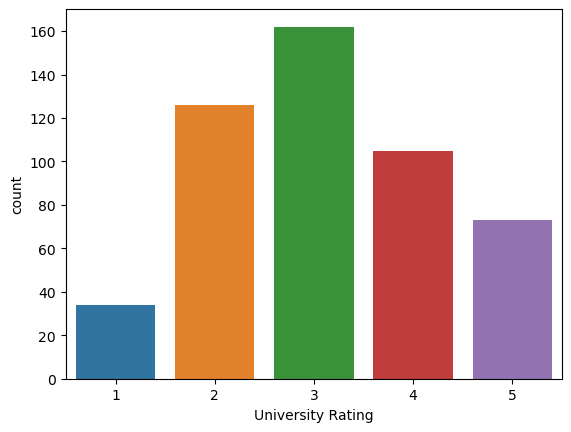

In [18]:
# University Rating

percent_comp = categorical_uni('University Rating')
percent_comp

### Insights:
>- 32% of universities in the dataset have rating 3 followed by 25% of rating 2 and 21% of rating 4
>- Majority of universities belong to category 2,3 and 4

,Percentage
1.0,1.2
1.5,5.0
2.0,8.6
2.5,12.8
3.0,16.0
3.5,17.6
4.0,17.8
4.5,12.6
5.0,8.4


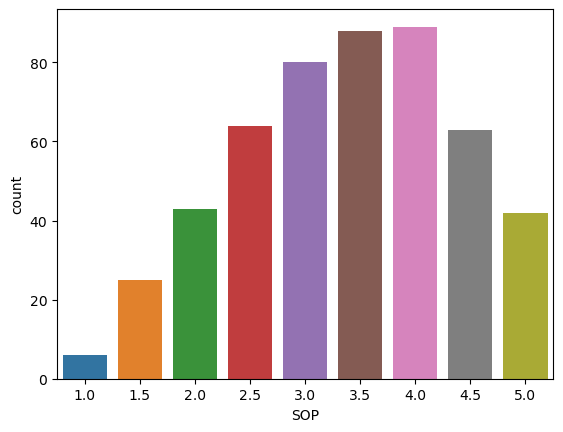

In [19]:
# SOP

categorical_uni('SOP')

### Insights:
>- 50% of the students received rating between 3 and 4 out of 5
>- Almost 20% of the students have rating of 4.5 and above out of 5
>- 25% of the students hava rating of 2.5 or below out of 5

,Percentage
1.0,0.2
1.5,2.2
2.0,9.2
2.5,10.0
3.0,19.8
3.5,17.2
4.0,18.8
4.5,12.6
5.0,10.0


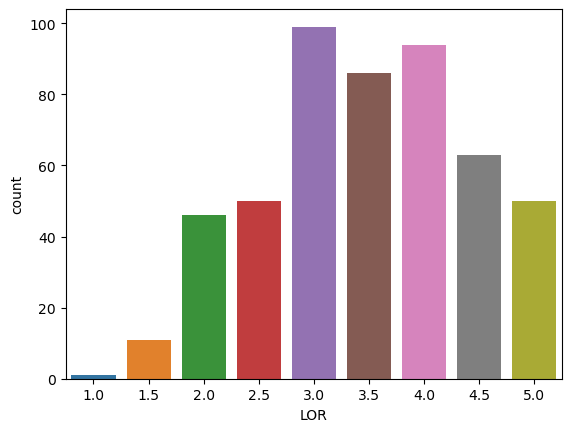

In [20]:
# LOR
categorical_uni('LOR')

### Insights:
>- More than 50% of the students got a rating between 3 and 4 out of 5
>- Almost 20% of the students have rating below 3 and similarly above 4.


,Percentage
0,44.0
1,56.0


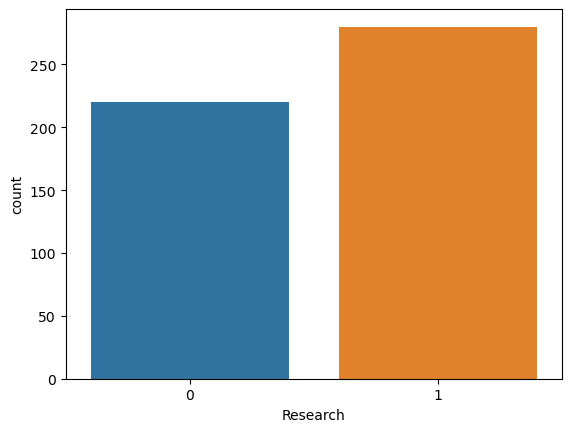

In [21]:
# Research

categorical_uni('Research')

### Insights:
>- 56% of students have a research experience while 44% do not
>- Distribution is almost equal

### Insights on Univariate Analysis:
>- Both categorical and numerical data is distributed well and not skewed
>- There is no presence of outliers or missing values
>- Relation between these variables need to be established before proceeding for model building

### Bivariate Analysis:
>-**Our target variable is Chance of Admit and we will establish relation between independent and dependent variables initially** 

In [22]:
# Defining functions for bivariate analysis

#for comparing 2 numerical variables

def numerical_biv(x, y):
    plt.figure(figsize=[15,5])
    
    plt.subplot(1,2,1)
    plt.title('Scatter Plot')
    sns.scatterplot(x = x, y= y, data = df)

    plt.subplot(1,2,2)
    plt.title('Line Plot')
    sns.lineplot(x = x, y = y, data = df)
    corr = np.corrcoef(df[x], df[y])[0][1]
    plt.show()
    print("Pearson's Correlation factor: ", corr)

#for comparing 2 categorical variables

def categorical_biv(x,y):
    plt.figure(figsize= [15,5])

    plt.subplot(1,2,1)
    sns.boxplot(x = x, y = y, data = df)

    plt.subplot(1,2,2)
    sns.histplot(x = df[y], hue = df[x])
    
    # ANOVA test to check relationship
    s = []
    categories = df[x].unique().to_list()
    for i in categories:
        s1 = df.loc[df[x]==i][y]
        s.append(s1)
     
    test, p_val= f_oneway(*s)
    print(f'p value for ANOVA test of relation between {x} and {y} is:', p_val)

    return df.groupby(x)[y].describe()

# function to convert categorical columns into contingency tables 
# and return p value of chisquared test

def chi_squared(cat1, cat2):
    size_cat1 = df[cat1].nunique()
    size_cat2 = df[cat2].nunique()
    lst = []
    for i in range(size_cat1):
        lst.append(pd.crosstab(df[cat1], df[cat2]).reset_index().iloc[i, 1:size_cat2 + 1].to_list())
    
    from scipy.stats import chi2_contingency
    stat, p, dof, expected = chi2_contingency(lst)
  
    print('p value for Chi Square test is:', p)
    return p


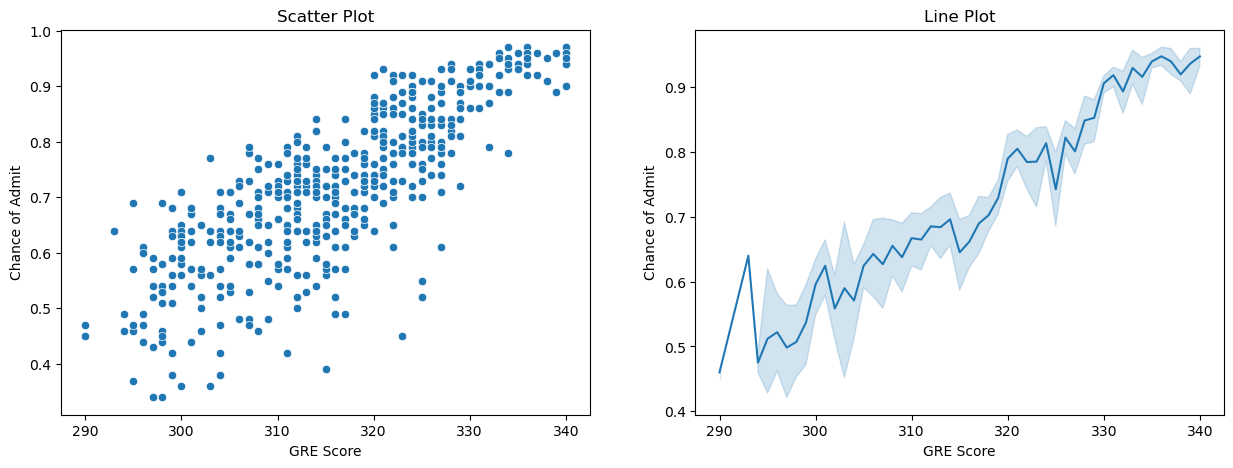

Pearson's Correlation factor:  0.8103506354632607


In [23]:
# GRE Score vs Chance of Admit

numerical_biv('GRE Score', 'Chance of Admit')

### Insights:
>- Pearson's correlation factor of 0.81 is very high showing high correlation with target variable
>- Scatter plot and lineplot also confirm the **positive correlation between GRE Score and Chance of Admit**
>- Most students with Chance of Admit greater than 0.7 concentrated above GRE Score of 310-315

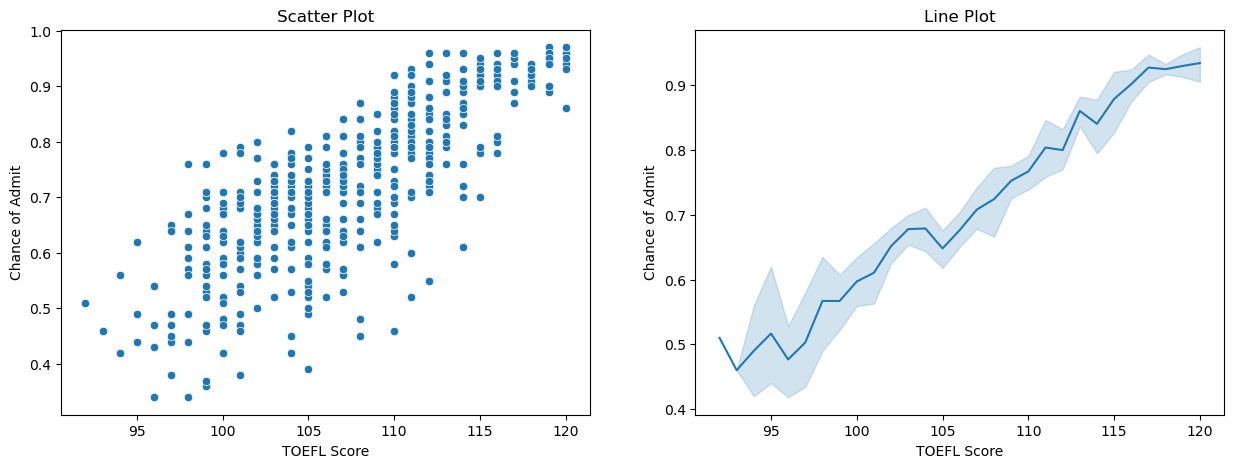

Pearson's Correlation factor:  0.7922276143050835


In [24]:
# TOEFL Score

numerical_biv('TOEFL Score', 'Chance of Admit' )

### Insights:
>- Pearson's correlation factor of 0.79 shows high correlation with target variable
>- Scatter plot and line plot also confirm **positive correlation between TOEFL Score and Chance of Admit**
>- Most students above TOEFL Score of 105 have a higher Chance of Admit above 0.7

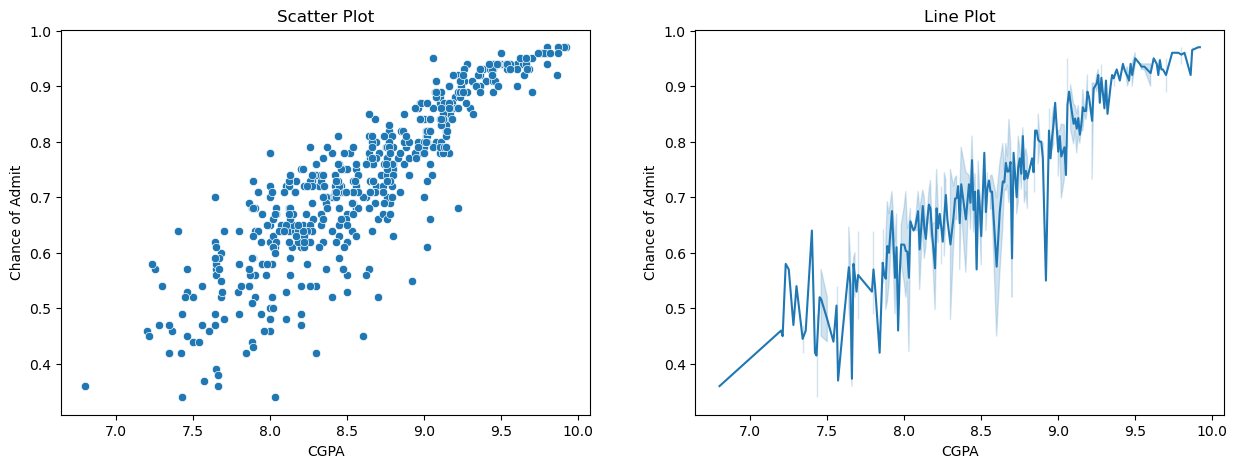

Pearson's Correlation factor:  0.8824125749045743


In [25]:
# CGPA vs Chance of Admit

numerical_biv('CGPA', 'Chance of Admit')

### Insights:
>- Pearson's correlation factor is very high at 0.88 swith target variable
>- Scatter plot and line plot also confirm the **high positive correlation between CGPA and Chance of Admit**
>- Most students with higher Chance of Admit above 0.7 got a CGPA of 8-8.5 or above

p value for ANOVA test of relation between University Rating and Chance of Admit is: 7.753395328023128e-69


,count,mean,std,min,25%,50%,75%,max
University Rating,,,,,,,,
1,34.0,0.562059,0.099446,0.36,0.5025,0.57,0.6075,0.79
2,126.0,0.626111,0.107859,0.34,0.5600,0.64,0.7000,0.90
3,162.0,0.702901,0.098427,0.36,0.6425,0.72,0.7700,0.90
4,105.0,0.801619,0.117327,0.42,0.7600,0.82,0.8900,0.97
5,73.0,0.888082,0.074715,0.61,0.8700,0.91,0.9400,0.97


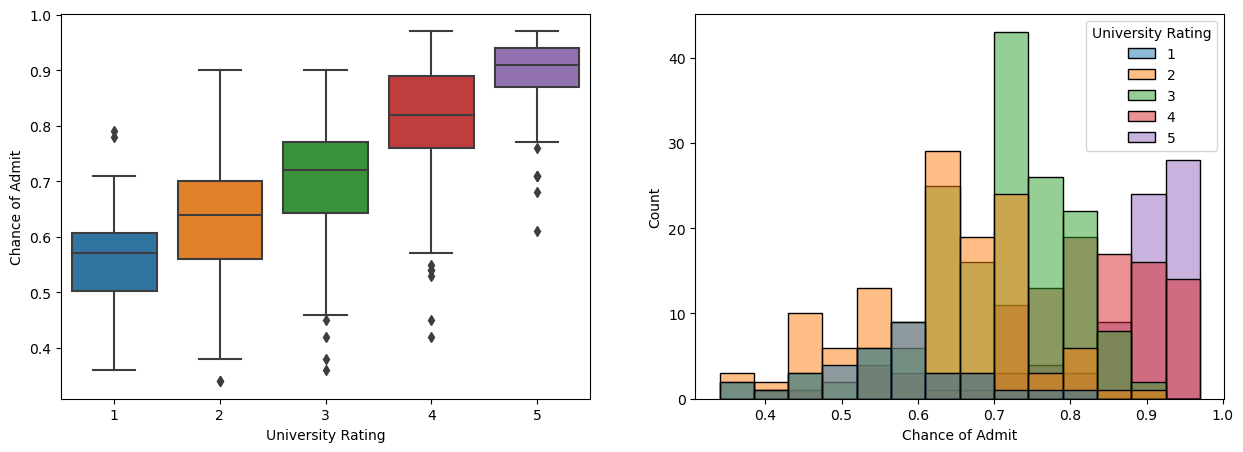

In [26]:
# University Rating

temp = categorical_biv('University Rating', 'Chance of Admit')
temp

### Insights:
>- Low p-value for ANOVA confirms correlation between two variables
>- As university rating increase, median value of Chance of Admit is increasing
>- It can also be seen in the histogram of Chance of Admit values. Higher rating universities appear on right side of the plot with higher Chance of Admit values
>- **Shows clear positive correlation between University Rating and Chance of Admit**
>- Chance of Admit is greater than 0.7 for students with University Rating of 3 or above

p value for ANOVA test of relation between SOP and Chance of Admit is: 2.1804735782708778e-64


,count,mean,std,min,25%,50%,75%,max
SOP,,,,,,,,
1.0,6.0,0.538333,0.062102,0.42,0.530,0.565,0.5775,0.58
1.5,25.0,0.546400,0.084749,0.42,0.490,0.540,0.5800,0.79
2.0,43.0,0.589535,0.118622,0.36,0.505,0.620,0.6600,0.81
2.5,64.0,0.645312,0.089265,0.34,0.590,0.665,0.7100,0.80
3.0,80.0,0.678500,0.106309,0.36,0.635,0.700,0.7500,0.91
3.5,88.0,0.712045,0.092104,0.45,0.650,0.730,0.7800,0.91
4.0,89.0,0.782809,0.123656,0.34,0.720,0.800,0.8700,0.97
4.5,63.0,0.850000,0.087584,0.57,0.790,0.870,0.9150,0.97
5.0,42.0,0.885000,0.106181,0.38,0.880,0.925,0.9400,0.96


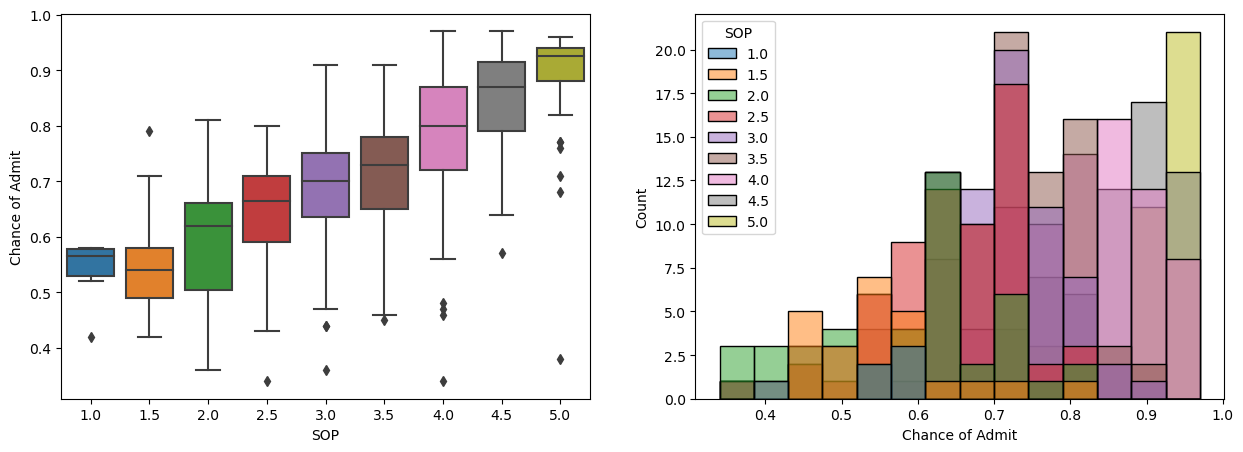

In [27]:
#SOP with Chance of Admit

temp = categorical_biv('SOP', 'Chance of Admit')
temp

### Insights:
>- Low p-value for ANOVA confirms correlation between two variables
>- Median value of Chance of Admit increases as SOP rating increases
>- Many categories under SOP show presence of outliers on lower side showing **some students with higher SOP ratings have also got low Chance of Admit**
>- Most students with rating of 3.5 and above received high Chance of Admit score
>- Histogram does not present a clear picture due to presence of 10 categories
>- **Positive correlation can still be established between SOP Rating and Chance of Admit**

p value for ANOVA test of relation between LOR and Chance of Admit is: 1.2475714296300458e-53


,count,mean,std,min,25%,50%,75%,max
LOR,,,,,,,,
1.0,1.0,0.420000,NaN,0.42,0.4200,0.420,0.4200,0.42
1.5,11.0,0.550000,0.122556,0.37,0.4950,0.520,0.5900,0.81
2.0,46.0,0.568261,0.102660,0.34,0.4900,0.565,0.6400,0.79
2.5,50.0,0.640600,0.116293,0.36,0.5825,0.650,0.7275,0.83
3.0,99.0,0.668485,0.111175,0.34,0.6200,0.660,0.7400,0.90
3.5,86.0,0.723023,0.121511,0.38,0.6625,0.720,0.7975,0.97
4.0,94.0,0.764149,0.103533,0.52,0.6900,0.770,0.8400,0.97
4.5,63.0,0.831905,0.104076,0.53,0.7650,0.870,0.9100,0.97
5.0,50.0,0.872600,0.083025,0.65,0.8225,0.910,0.9400,0.97


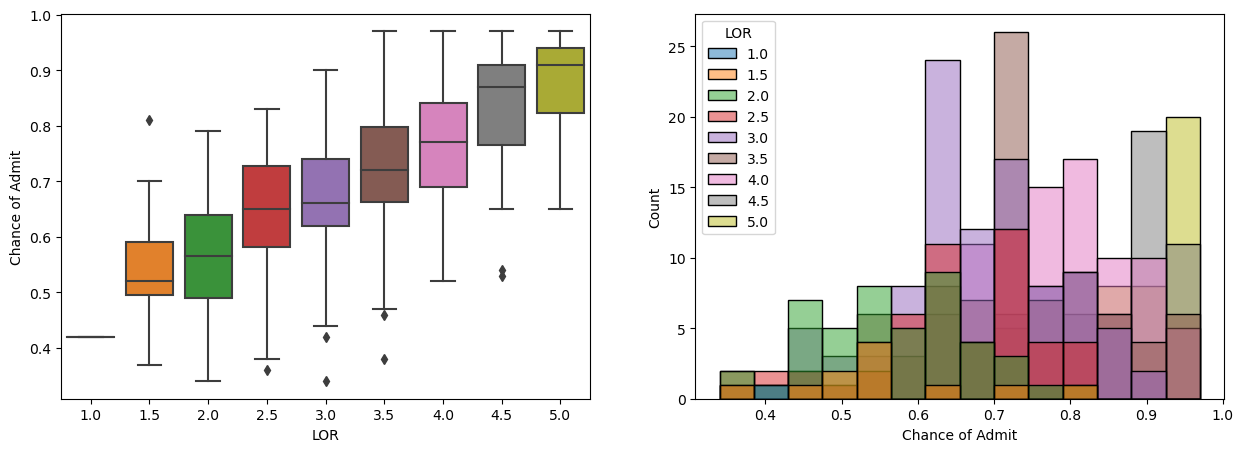

In [28]:
# LOR with Chance of Admit

temp = categorical_biv('LOR', 'Chance of Admit')
temp

### Insights:
>- Low p-value for ANOVA confirms correlation between two variables
>- Median value of Chance of Admit increases as LOR rating increases
>- Histogram does not present a clear picture due to presence of 10 categories
>- Most students with LOR rating of 3.5 and above received higher Chance of Admit score of 0.7 or above
>- **Positive correlation can still be established between LOR Rating and Chance of Admit**

p value for ANOVA test of relation between Research and Chance of Admit is: 3.5954935458406797e-40


,count,mean,std,min,25%,50%,75%,max
Research,,,,,,,,
0,220.0,0.634909,0.111918,0.34,0.5675,0.645,0.7100,0.89
1,280.0,0.789964,0.123208,0.36,0.7200,0.800,0.8925,0.97


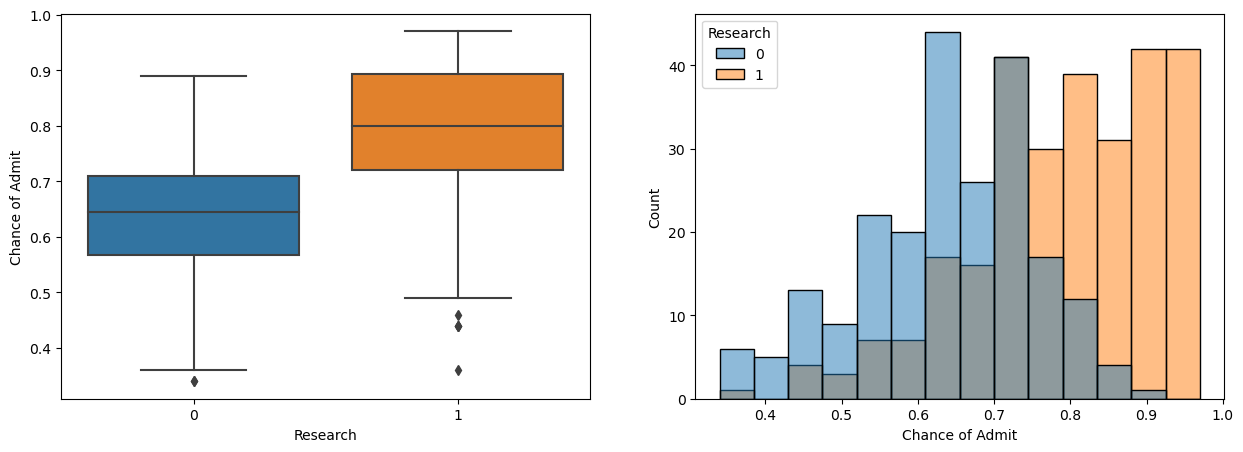

In [29]:
# Research vs Chance of Admit

temp = categorical_biv('Research', 'Chance of Admit')
temp

### Insights:
>- Low p-value for ANOVA confirms correlation between two variables
>- It can be clearly seen that students with research experience have a higher chance of admit score
>- Median score of students without research is 0.65 while for those with experience is 0.8 approximately

##### We will analyse relation between some independent variables to see how it can affect our model

In [7]:
num_cols = ['GRE Score', 'TOEFL Score', 'CGPA']
cat_cols = ['University Rating', 'SOP', 'LOR', 'Research']

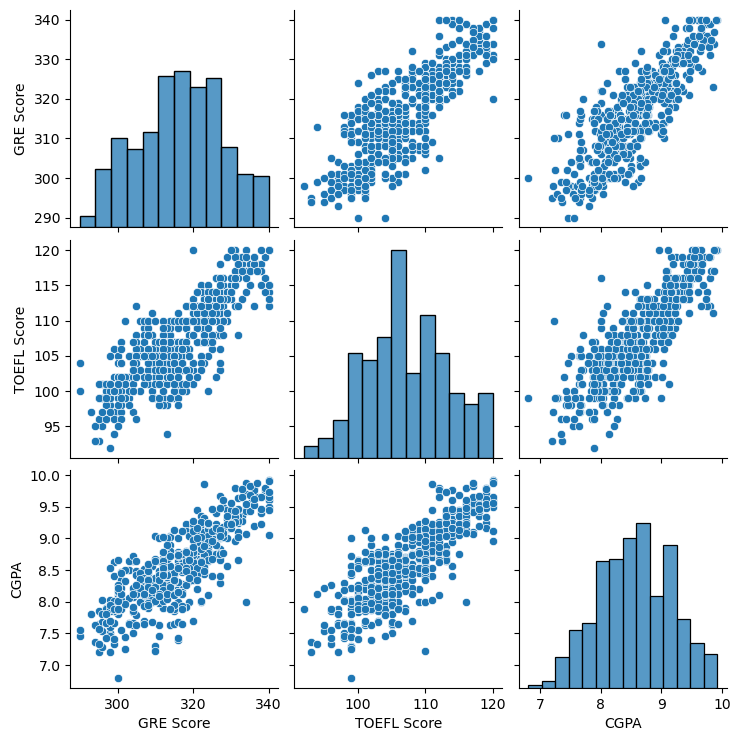

In [31]:
#plotting pairplot for numerical variables

sns.pairplot(df[num_cols])

,GRE Score,TOEFL Score,CGPA
GRE Score,1.000000,0.827200,0.825878
TOEFL Score,0.827200,1.000000,0.810574
CGPA,0.825878,0.810574,1.000000


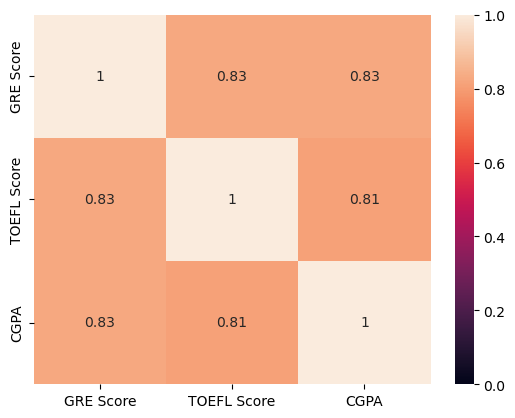

In [8]:
#Correlation scores and heatmap for numerical variables

sns.heatmap(df[num_cols].corr(),annot = True, vmin = 0, vmax= 1)
df[num_cols].corr()

### Insights:
>- As seen in both scatterplot and heatmap of correlation matrix, **there is high positive correaltion between GRE Score, TOEFL Score and CGPA**
>- Hints at the logical conclusion that high CGPA reflects in GRE and TOEFL examination scores 
>- **As independent numerical variables are having high positive correlation with each other as well as target variable, these will share the same relation with all categorical variables**
>- **This implies, all categorical variables will also share positive correlation with numerical variables**

##### Checking relationship of one categorical variable University Rating (which has high positive correlation with Chance of Admit) with remaining categorical variable:-

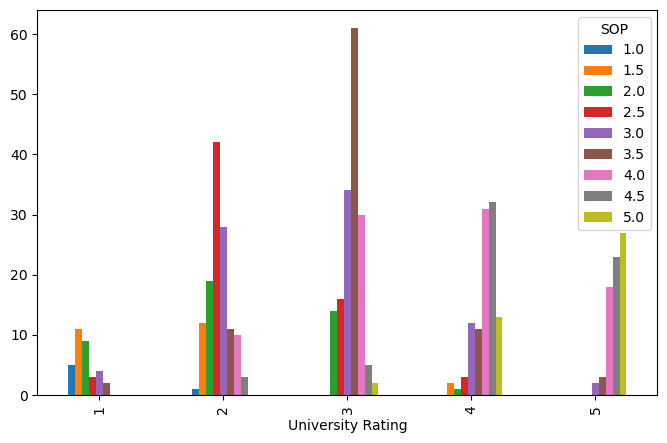

p value for Chi Square test is: 6.90929994702165e-82


6.90929994702165e-82

In [33]:
#Testing dependence of University Rating and SOP

pd.crosstab(df["University Rating"], df["SOP"]).plot(kind='bar',figsize = [8,5])
plt.show()
chi_squared('University Rating', 'SOP')    

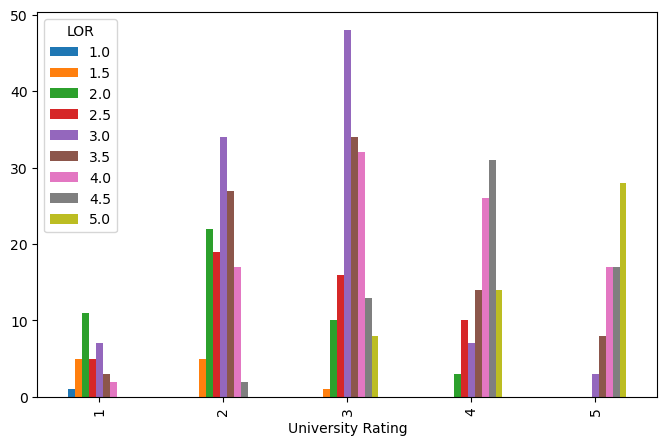

p value for Chi Square test is: 6.7413722418928954e-40


6.7413722418928954e-40

In [34]:
#Testing dependence of University Rating and LOR

pd.crosstab(df["University Rating"], df["LOR"]).plot(kind='bar',figsize = [8,5])
plt.show()
chi_squared('University Rating', 'LOR')

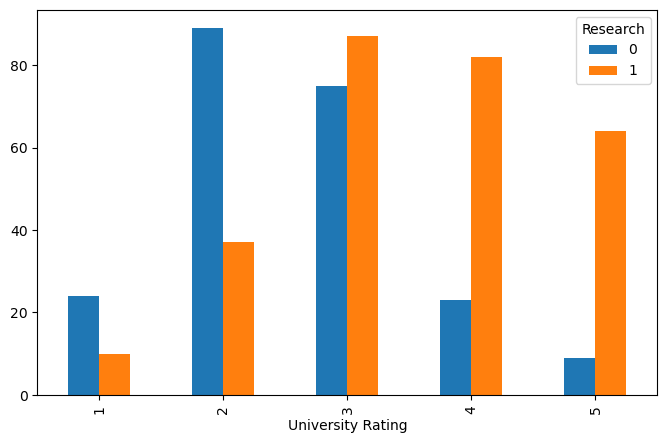

p value for Chi Square test is: 4.4936229585994394e-20


4.4936229585994394e-20

In [35]:
#Testing dependence of University Rating and Research Experience

pd.crosstab(df["University Rating"], df["Research"]).plot(kind='bar',figsize = [8,5])
plt.show()
chi_squared('University Rating', 'Research')

### Insights:
>- It can be seen with result of Chi Squared test that **SOP, LOR and Research experience are related to University Rating** and they are not independent variables
>- **Higher value of University rating is seen with higher values of SOP, LOR scores and presence of Research Experience**
>- It could also mean that all categorical variables are related to each other too
>- This can lead to multicollinearity in our Linear Regression model

### Conclusion from EDA:
>- All independent variables are correlated with the target variable Chance of Admit
>- All independent variables are also positively correlated with each other which can cause multicollinearity in the model

## 2. Data Preprocessing

**Duplicate value check is not needed in this dataset due to type of this data and no missing values were found. Outlier check has also been done. Data can be scaled for model building now.**

In [36]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


>- GRE Score, TOEFL Score and CGPA can be scaled using Standard scaling
>- Target variable Chance of Admit can be left untouched 
>- As categorical variables are ordinal in this case, we will scale it using Standard Scaling as it will retain the order of the variables and the differences between values too

In [37]:
# creating a copy of original data

df_orig = df

In [38]:
# Scaling of all columns except Chance of Admit

from sklearn.preprocessing import StandardScaler

df_ind = df.drop('Chance of Admit', axis = 1)
scaler = StandardScaler()
std_data = scaler.fit_transform(df_ind)
std_data = pd.DataFrame(std_data, columns=df_ind.columns)
std_data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,1.819238,1.778865,0.775582,1.137360,1.098944,1.776806,0.886405
1,0.667148,-0.031601,0.775582,0.632315,1.098944,0.485859,0.886405
2,-0.041830,-0.525364,-0.099793,-0.377773,0.017306,-0.954043,0.886405
3,0.489904,0.462163,-0.099793,0.127271,-1.064332,0.154847,0.886405
4,-0.219074,-0.689952,-0.975168,-1.387862,-0.523513,-0.606480,-1.128152


In [39]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [40]:
# Concatenating Chance of Admit data to scaled data

df = pd.concat([std_data, df['Chance of Admit']] ,axis = 1)
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1.819238,1.778865,0.775582,1.137360,1.098944,1.776806,0.886405,0.92
1,0.667148,-0.031601,0.775582,0.632315,1.098944,0.485859,0.886405,0.76
2,-0.041830,-0.525364,-0.099793,-0.377773,0.017306,-0.954043,0.886405,0.72
3,0.489904,0.462163,-0.099793,0.127271,-1.064332,0.154847,0.886405,0.80
4,-0.219074,-0.689952,-0.975168,-1.387862,-0.523513,-0.606480,-1.128152,0.65


#### Data preprocessing is complete and all the features are scaled for model building. 

## 3. Model Building

> **Initially we will check for Multicollinearity in independent features with VIF before building model**

In [175]:
# Separating independent and dependent variables in X and y respectively

X = df.drop('Chance of Admit', axis = 1)
y = df['Chance of Admit']

In [42]:
# Creating table with feature names and respective VIF scores

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
5,CGPA,4.78
0,GRE Score,4.46
1,TOEFL Score,3.90
3,SOP,2.84
2,University Rating,2.62
4,LOR,2.03
6,Research,1.49


### Insights:
>- As seen all the features have a **VIF less than 5 and therefore need not be dropped**
>- **Assumptions related to residuals for Linear Regression will be checked once the model selection is done**

### Types of models to be checked:
1. Initially we will build a **Linear Regression model with Kfold cross validation** to see its performance
2. This will be **followed by Grid Search cross validation by varying number of features in Recursive Feature Extraction (RFE) based regression** to see if performance improves
3. Finally we will build **Ridge and Lasso regression models** with grid search cross validation by varying the value of hyperparameter lambda (or alpha)

In [176]:
# creating training and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, random_state= 0)

### Creating Linear Regression model with K-Fold cross validation

In [177]:
#creating model using sklearn library's LinearRegression module

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [178]:
# Checking R2 values for K-fold cross validation with 5 folds

cv1 = cross_val_score(model, X_train, y_train, cv = 5)
np.round(cv1,3)

array([0.727, 0.879, 0.787, 0.849, 0.835])

In [46]:
# checking mean and standard deviation of the R2 score for each validation:

print(f'Mean of R2 score for validation folds: {cv1.mean()}')
print(f'Standard Deviation of R2 score for validation folds: {cv1.std()}')

Mean of R2 score for validation folds: 0.8153971476464863
Standard Deviation of R2 score for validation folds: 0.05297938728056749


### Insights on Validation data test:
>-  As seen from R2 scores on validation data, **values range between 0.73 and 0.88**
>- **Mean of R2 score is 0.81.**
>- This shows **low bias in model but has some variance due to inconsistency in model performance on validation data**
>- Standard deviation of R2 scores on 5 folds validation is 0.053 which is not very high 

In [179]:
# Checking R2 value of model for training data

model.score(X_train, y_train)

0.8317861130579625

In [180]:
#predicted target variable values based on input test data

y_hat = model.predict(X_test)

#Evaluating model

R2 = model.score(X_test, y_test)
mse = metrics.mean_squared_error(y_test, y_hat)
mae = metrics.mean_absolute_error(y_test, y_hat)
adj_R2 = 1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

print(f'R2 Score for test data: {R2}')
print()
print(f'Adjusted R2 Score for test data: {adj_R2}')
print()
print(f'Mean Squared Error for test data: {mse}')
print()
print(f'Mean Absolute Error for test data: {mae}')


R2 Score for test data: 0.7910195074277856

Adjusted R2 Score for test data: 0.7807176521601412

Mean Squared Error for test data: 0.0038128490869800517

Mean Absolute Error for test data: 0.04534771104286275


### Insights on training and test scores, Mean Squared error:
>- Model gave **high R2 score on training as well as test data** which shows it is a **low bias model**
>- Mean Squared Error value is also very low at 0.004 showing strength of model
>- **This model will be compared with RFE based Linear Regression model and Ridge and Lasso Regression models to decide on final model to be chosen**

_________________

### Creating Recursive Feature Extraction (RFE) based Linear Regression model
> **We will use GridSearch Cross Validation to arrive at best value of hyperparameter (number of features to be selected) for the model.**
> **We will vary the hyperparameter value from [3-7] to arrive at optimal value. (Total features in dataset = 7)** 

In [181]:
#creating folds to be used as argument in GridSearchCV method

folds = KFold(n_splits= 5, shuffle = True, random_state= 100)

In [182]:
#creating dictionary of hyperparameter (no. of features to be selected) 
# range of values given from (3,8)

hyper_params = [{'n_features_to_select': list(range(3,8))}]

#specify model
lm = LinearRegression()
lm.fit(X_train, y_train)

#creating RFE estimator for feature selection
rfe = RFE(lm)

# call gridsearch
model_cv = GridSearchCV(estimator = rfe,
                       param_grid= hyper_params,
                       scoring = 'r2',
                       cv = folds,
                       verbose = 1,
                       return_train_score= True)

#fit model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [3, 4, 5, 6, 7]}],
             return_train_score=True, scoring='r2', verbose=1)

In [183]:
#Best Estimator- optimal values of number of features to be selected

model_cv.best_estimator_

RFE(estimator=LinearRegression(), n_features_to_select=6)

In [184]:
#List of selected Features by RFE

pd.DataFrame(X_train.columns[model_cv.best_estimator_.support_], columns= ['Features'])

,Features
0,GRE Score
1,TOEFL Score
2,University Rating
3,LOR
4,CGPA
5,Research


>- **Best results** of R2 score and cross validation data **came with 6 Number of features**
>- **SOP feature was dropped** in the above algorithm and rest of the features were retained
>- **We will create a Linear Regression model based on above result.**

In [185]:
#Creating Linear Regression model for RFE based output

#create train and test data dropping SOP from input data

X = df.drop(['SOP', 'Chance of Admit'], axis = 1)   
y = df['Chance of Admit']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, random_state= 11)

#fit model
model_RFE = LinearRegression()
model_RFE.fit(X_train, y_train)

# Checking R2 values for K-fold cross validation with 5 folds

cv1 = cross_val_score(model_RFE, X_train, y_train, cv = 5)
np.round(cv1,3)

array([0.843, 0.821, 0.833, 0.714, 0.803])

In [55]:
# checking mean and standard deviation of the R2 score for each validation:

print(f'Mean of R2 score for validation folds: {cv1.mean()}')
print(f'Standard Deviation of R2 score for validation folds: {cv1.std()}')

Mean of R2 score for validation folds: 0.8026527334801777
Standard Deviation of R2 score for validation folds: 0.04630409602204503


### Insights on Validation data test:
>-  As seen from R2 scores on validation data, **values range between 0.71 and 0.84**
>- **Mean of R2 score is 0.80.**
>- This shows **low bias in model but has some variance due to inconsistency in model performance on validation data**
>- Standard deviation of R2 scores on 5 folds validation is 0.053 which is not very high 

In [56]:
# Checking R2 value of model for training data

model_RFE.score(X_train, y_train)

0.8144405566650728

In [57]:
#predicted target variable values based on input test data

y_hat = model_RFE.predict(X_test)

#Evaluating model

R2 = model_RFE.score(X_test, y_test)
mse = metrics.mean_squared_error(y_test, y_hat)
mae = metrics.mean_absolute_error(y_test, y_hat)
adj_R2 = 1 - (1-model_RFE.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

print(f'R2 Score for test data: {R2}')
print()
print(f'Adjusted R2 Score for test data: {adj_R2}')
print()
print(f'Mean Squared Error for test data: {mse}')
print()
print(f'Mean Absolute Error for test data: {mae}')


R2 Score for test data: 0.8376663071324812

Adjusted R2 Score for test data: 0.830855103235942

Mean Squared Error for test data: 0.0029037529497062354

Mean Absolute Error for test data: 0.04185196587105425


### Insights on training and test scores, Mean Squared error:
>- Model gave **high R2 score on training as well as test data** which shows it is a **low bias model**
>- Mean Squared Error value is also very low at 0.003 showing strength of model

>- **R2 score for test data on RFE based model at 0.84 is better than earlier model which gave R2 score of 0.79**
>- **Mean Squared Error for test data on RFE based model at 0.003 is better than earlier model which gave MSE of 0.004**

##### Therefore RFE based model after eliminating one feature (SOP) performs better than earlier model which had all the features.
>- **This Linear Regression model will be compared with Ridge and Lasso Regression models to decide on final model to be chosen**

_____________________

### Creating Ridge Regression model
> **We will use GridSearch Cross Validation to arrive at best value of hyperparameter (lambda or alpha) for the model.**  
> **We will vary the hyperparameter value multiple times to arrive at optimal value.** 

In [58]:
#create train and test data dropping SOP from input data

X = df.drop(['SOP', 'Chance of Admit'], axis = 1)   
y = df['Chance of Admit']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, random_state= 11)

#specify model
ridge = Ridge()

#checking alpha values between 1 and 100
hyper_params = [{'alpha':np.linspace(1,101,21)}]

# call gridsearch
model_cv = GridSearchCV(estimator = ridge,
                       param_grid= hyper_params,
                       scoring = 'r2',
                       cv = folds,
                       verbose = 1,
                       return_train_score= True)



#fit model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Ridge(),
             param_grid=[{'alpha': array([  1.,   6.,  11.,  16.,  21.,  26.,  31.,  36.,  41.,  46.,  51.,
        56.,  61.,  66.,  71.,  76.,  81.,  86.,  91.,  96., 101.])}],
             return_train_score=True, scoring='r2', verbose=1)

In [59]:
#checking value of alpha with best result

model_cv.best_estimator_

Ridge(alpha=16.0)

>- **Best performance of Ridge regression model was seen with alpha value at 16.**
>- **We will further finetune the value of alpha between 1 and 16 to get a more precise value.**

In [60]:
#specify model
ridge = Ridge()

#checking alpha values between 1 and 16
hyper_params = [{'alpha':np.linspace(1,16,21)}]

# call gridsearch
model_cv = GridSearchCV(estimator = ridge,
                       param_grid= hyper_params,
                       scoring = 'r2',
                       cv = folds,
                       verbose = 1,
                       return_train_score= True)

#fit model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Ridge(),
             param_grid=[{'alpha': array([ 1.  ,  1.75,  2.5 ,  3.25,  4.  ,  4.75,  5.5 ,  6.25,  7.  ,
        7.75,  8.5 ,  9.25, 10.  , 10.75, 11.5 , 12.25, 13.  , 13.75,
       14.5 , 15.25, 16.  ])}],
             return_train_score=True, scoring='r2', verbose=1)

In [61]:
#checking value of alpha with best result

model_cv.best_estimator_

Ridge(alpha=14.5)

In [62]:
# R2 score of validation data with alpha = 14.5

model_cv.best_score_

0.7946732618147889

>- **After Gridsearch Cross validation, we found value of alpha for best model to be 14.5**
>- **The R2 score for validation data is 0.79 which shows low bias**
>- We will be checking the model performance based on test data:

In [63]:
# Checking R2 value of model for training data

model_cv.best_estimator_.score(X_train, y_train)

0.8135639760871842

In [64]:
#predicted target variable values based on input test data

y_hat = model_cv.best_estimator_.predict(X_test)

#Evaluating model

R2 = model_cv.best_estimator_.score(X_test, y_test)
mse = metrics.mean_squared_error(y_test, y_hat)
mae = metrics.mean_absolute_error(y_test, y_hat)
adj_R2 = 1 - (1-model_cv.best_estimator_.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

print(f'R2 Score for test data: {R2}')
print()
print(f'Adjusted R2 Score for test data: {adj_R2}')
print()
print(f'Mean Squared Error for test data: {mse}')
print()
print(f'Mean Absolute Error for test data: {mae}')


R2 Score for test data: 0.8369468076300217

Adjusted R2 Score for test data: 0.8301054149431695

Mean Squared Error for test data: 0.0029166230370286732

Mean Absolute Error for test data: 0.04199264285966357


### Insights on training and test scores, Mean Squared error:
>- Model gave **high R2 score on training as well as test data** which shows it is a **low bias model**
>- Mean Squared Error value is also very low at 0.003 showing strength of model

>- **R2 score for test data on Ridge Regression based model at 0.84 is same as earlier RFE based model which gave R2 score of 0.84 too**
>- **Mean Squared Error for test data on Ridge Regression based model at 0.003 is same as earlier model which gave MSE of 0.003**

##### Therefore Ridge regression model after eliminating one feature (SOP) performs almost same as earlier RFE based model .
>- **This Ridge Regression model will be compared with Lasso Regression model to decide on final model to be chosen**

________

### Creating Lasso Regression model
> **We will use GridSearch Cross Validation to arrive at best value of hyperparameter (lambda or alpha) for the model.**  
> **We will vary the hyperparameter value multiple times to arrive at optimal value.** 

In [65]:
#create train and test data dropping SOP from input data

X = df.drop(['SOP', 'Chance of Admit'], axis = 1)   
y = df['Chance of Admit']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, random_state= 11)


#specify model
lasso = Lasso()

hyper_params = [{'alpha': np.linspace(0, 0.02, 11)}]

# call gridsearch
model_cv = GridSearchCV(estimator = lasso,
                       param_grid= hyper_params,
                       scoring = 'r2',
                       cv = folds,
                       verbose = 1,
                       return_train_score= True)

#fit model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.399e-01, tolerance: 5.310e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Lasso(),
             param_grid=[{'alpha': array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
       0.018, 0.02 ])}],
             return_train_score=True, scoring='r2', verbose=1)

In [66]:
#checking value of alpha with best result

model_cv.best_estimator_

Lasso(alpha=0.002)

>- **Best performance of Lasso regression model was seen with alpha value at 0.002.**
>- **We will further finetune the value of alpha between 0 and 0.002 to get a more precise value.**

In [67]:
#specify model
lasso = Lasso()

hyper_params = [{'alpha': np.linspace(0, 0.002, 11)}]

# call gridsearch
model_cv = GridSearchCV(estimator = lasso,
                       param_grid= hyper_params,
                       scoring = 'r2',
                       cv = folds,
                       verbose = 1,
                       return_train_score= True)

#fit model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.399e-01, tolerance: 5.310e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Lasso(),
             param_grid=[{'alpha': array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014,
       0.0016, 0.0018, 0.002 ])}],
             return_train_score=True, scoring='r2', verbose=1)

In [68]:
#checking value of alpha with best result

model_cv.best_estimator_

Lasso(alpha=0.0014)

In [69]:
# R2 score of validation data with alpha = 14.5

model_cv.best_score_

0.7936576912616377

>- **After Gridsearch Cross validation, we found value of alpha for best model to be 0.0014**
>- **The R2 score for validation data is 0.79 which shows low bias**
>- We will be checking the model performance based on test data:

In [70]:
# Checking R2 value of model for training data

model_cv.best_estimator_.score(X_train, y_train)

0.8142877047005824

In [71]:
#predicted target variable values based on input test data

y_hat = model_cv.best_estimator_.predict(X_test)

#Evaluating model

R2 = model_cv.best_estimator_.score(X_test, y_test)
mse = metrics.mean_squared_error(y_test, y_hat)
mae = metrics.mean_absolute_error(y_test, y_hat)
adj_R2 = 1 - (1-model_cv.best_estimator_.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

print(f'R2 Score for test data: {R2}')
print()
print(f'Adjusted R2 Score for test data: {adj_R2}')
print()
print(f'Mean Squared Error for test data: {mse}')
print()
print(f'Mean Absolute Error for test data: {mae}')


R2 Score for test data: 0.8385889808598289

Adjusted R2 Score for test data: 0.8318164905462553

Mean Squared Error for test data: 0.0028872485721486516

Mean Absolute Error for test data: 0.04162380759340168


### Insights on training and test scores, Mean Squared error:
>- Model gave **high R2 score on training as well as test data** which shows it is a **low bias model**
>- Mean Squared Error value is also very low at 0.003 showing strength of model

>- **R2 score for test data on Lasso Regression based model at 0.84 is same as earlier Ridge Regression and RFE based Linear Regression model which gave R2 score of 0.84 too**
>- **Mean Squared Error for test data on Lasso Regression based model at 0.003 is same as earlier Ridge Regression and RFE based Linear Regression model which gave MSE of 0.003**

### Therefore Lasso regression model after eliminating one feature (SOP) performs almost same as earlier Ridge Regression as well as RFE based Linear Regression model .

_____________

In [72]:
#Summary of performance results of 4 models

pd.DataFrame({'Linear Regression': [0.79,0.0038], 'RFE + Lin Reg':[0.8376, 0.0029], 
              'Ridge Reg': [0.8368, 0.0029], 'Lasso Reg': [0.8386, 0.0029]}, index = ['R2 Score', 'Mean Squared Error'])

,Linear Regression,RFE + Lin Reg,Ridge Reg,Lasso Reg
R2 Score,0.7900,0.8376,0.8368,0.8386
Mean Squared Error,0.0038,0.0029,0.0029,0.0029


>##### Therefore it can be seem that Lasso Regression model performs mildy better than other 3 models and may be selected for our purpose
> Further evaluation on performance of model will be done after testing for assumptions of linear regression
 

## 4. Testing for Assumptions of Linear Regression:

In [73]:
# Recreating same Lasso Regression model with alpha = 0.0014 for testing assumptions

mld = Lasso(alpha = 0.0014)
mld.fit(X_train, y_train)

Lasso(alpha=0.0014)

#### 1. Mean of residuals is nearly zero

In [74]:
#calculating residuals

y_pred = mld.predict(X_test)

error = y_pred -y_test

In [75]:
# Calculating mean of residuals

np.mean(error)

-0.012860227769343412

>- **As seen, mean of residuals at -0.012 is nearly zero**

#### 2. Test for Autocorrelation (Observations of the error term are uncorrelated with each other)

Text(0.5, 0, 'Index')

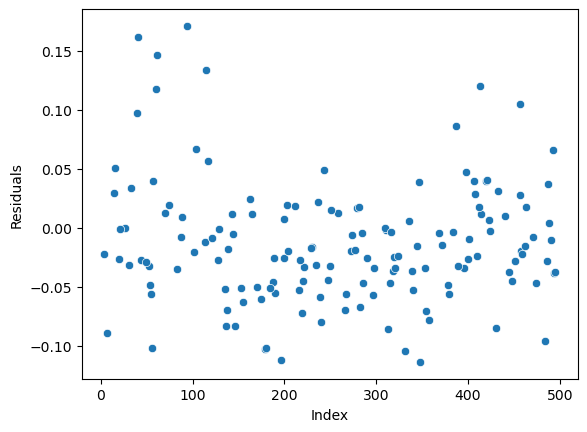

In [78]:
sns.scatterplot(x = error.index,y= error)
plt.ylabel('Residuals')
plt.xlabel('Index')

### Insights:
>- **No autocorrelation can be found in residuals which shows that observations were picked randomly**

#### 3. Linearity of variables (no pattern in the residual plot) 

Text(0, 0.5, 'Residuals')

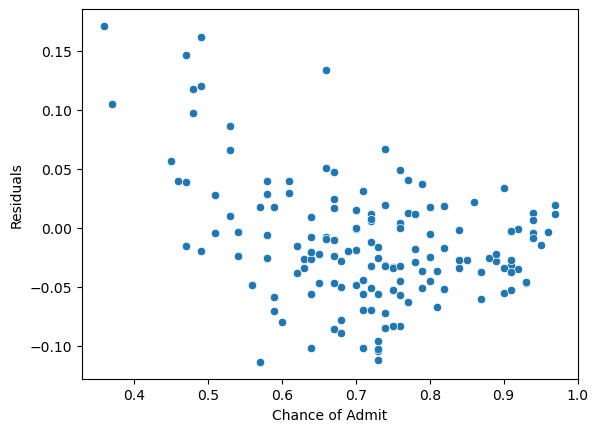

In [76]:
# plotting residuals vs target variable plot

sns.scatterplot(x = y_test, y = error)
plt.ylabel('Residuals')

### Insights:
>- **No pattern is visible in the residual plot broadly**
>- **The condition is met properly above the target variable value of 0.6**

#### 4. Test for Homoscedasticity (error is constant along the values of the dependent variable)

>- **As seen in the residuals vs target variable scatter plot above, variance can be observed in residuals**
>- For **values of target variable above 0.6 homoscedasticity or constant variance of error can be observed**
>- **Outliers in residuals can be seen for values of target variable below 0.6**
>- It means homoscedasticity was not observed completely for all observations
>- It could mean that some variable needs to be added or removed from the data

#### 5. Normality of Residuals (residuals should follow a normal distribution)

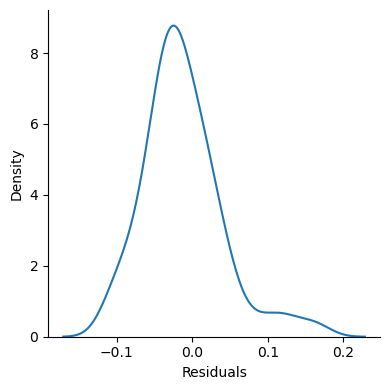

In [87]:
#plotting residulas distribution

sns.displot(error, kind = 'kde', height= 4)
plt.xlabel('Residuals')
plt.show()

<Figure size 400x300 with 0 Axes>

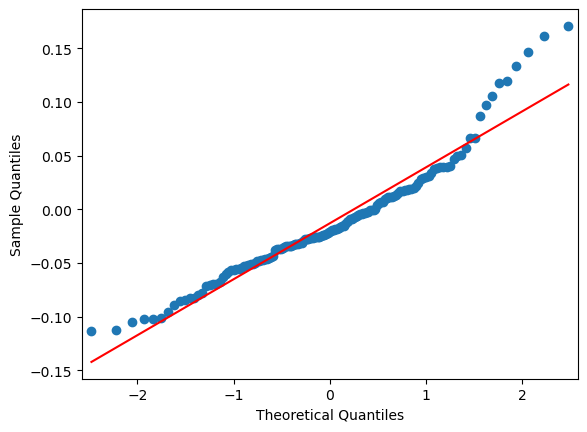

In [302]:
# checking normality with QQ plot

import scipy.stats as stats
sm.qqplot(error, dist=stats.norm, line='s');

### Insights:
>- As seen in residuals distribution plot, **bell shaped curve is formed with mean close to 0**
>- In QQ plot, it can be observed that **residuals fall on red line(representing normal distribution) for most part**
>- In the top right corner of plot representing higher values of residual errors, normal distribution is not followed well

_____

## 5. Model Performance Evaluation

In [92]:
# Mean Squared error and Mean absolute error for model

mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error for test data: {mse}')
print()
print(f'Mean Absolute Error for test data: {mae}')

Mean Squared Error for test data: 0.0028872485721486516

Mean Absolute Error for test data: 0.04162380759340168


In [119]:
# K fold cross validation score

cv_mld = cross_val_score(mld, X_train, y_train, cv = 5)
print('Mean validation score:', cv_mld.mean())
print('Standard Deviation in score: ',np.std(cv_mld, ddof=1) )
cv_mld

Mean validation score: 0.8025400081109367
Standard Deviation in score:  0.05185370505166479


array([0.84298914, 0.82073201, 0.83161795, 0.7134295 , 0.80393144])

In [88]:
# train performance

mld.score(X_train, y_train)

0.8142877047005824

In [89]:
# test performance

mld.score(X_test, y_test)

0.8385889808598289

In [90]:
#Adjusted R2 value

adj_R2 = 1 - (1-mld.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adj_R2

0.8318164905462553

In [114]:
# Checking coefficient values for each feature

coef = np.round(mld.coef_,4)
cols = X.columns
col_coef = dict(zip(cols, coef))
col_coef = pd.DataFrame(col_coef, index = ['Coefficient Values'])
col_coef = col_coef.T
col_coef.sort_values(by = 'Coefficient Values', ascending = False)

,Coefficient Values
CGPA,0.0728
GRE Score,0.0189
TOEFL Score,0.0174
LOR,0.0150
Research,0.0120
University Rating,0.0086


### Insights on model performance:
>- In Kfold cross validation, the **mean validation score is 0.80 and standard deviation is 0.05.** 
>- **Mean squared error in model is close to 0 at 0.003.**
>- Model shows a **good R2 score of 0.84 on test data** and 0.81 on training data
>- It **performed better on test data compared to training data**
>- All of above metrics reflect good performance of model with **low bias and low variance**

__________

## 6. Actionable Insights and Recommendations

### Actionable Insights based on model:
>1. **CGPA has the highest weightage** in determining Chance of admission

>2. **University Rating has the lowest weightage** in determining chance of admission

>3. **All the coefficients are positive showing positive correlation of all the features with chance of admission.**

>4. **SOP was dropped before building our model as it was found to be not contributing in prediction of target variable**. This could be due multicollinearity, i.e. it was not independent of other features and could have resulted in skewed results

>5. Model was found to be **low bias (high R2 score )and low variance(low standard deviation in cross validation)**. This makes the **model more robust and trustworthy** for implementaion on new datasets 

>6. **Most of the assumptions of Linear Regression were satisfied** meaning that this data was suitable for Linear Regression model 

>7. Most of the features were found to positively correlated with each other as well as target variable and that was established statiscally

### Business Recommendations:

**For interpretation of the model, it can be said that the coefficient value signifies how much the mean of the Chance of Admission changes given a one-unit shift in the input variable while holding other variables constant**

>1. From our analysis, it was found that **CGPA had the highest contribution in a student's chance of admission followed by GRE Score and TOEFL Score** to a college and they need special focus from students' perspective.

>2. **University Rating, on the other hand has lowest contribution in Chance of Admission**. This can be an encouraging news to all the students applying from lower rated universities.

>3. As **SOP was not found to be impacting Chance of Admission significantly**, more attention can be given to other aspects like CGPA, Letter of recommendation, GRE score etc

>4. **Since all the features showed positive correlation with each other**, it means improvement in one aspect of student's profile may have a positive impact on other aspects too. For example, higher CGPA can be associated with higher GRE scores as both reflect aptitude and quality of student's preparation. 

>5. For predicting chance of admission of a student, the sum of coefficients generated by our model multiplied by value of respective variables may be used to arrive at the probability value of admission;  
y = w0 + (w1 * x1) + (w2 * x2) + (w3 * x3) +...

>6. **Information on importance of certain features** over above and **presence of a tool to generate accurate probabilities** of admission can be very helpful in **new customer acquisition** and must be promoted. It provides **certainty, transparency to students regarding their future and develops trust towards Jamboree Education** as a partner

>7. **More data** can be collected from students like:
>>- Geographical data 
>>- Field of Education to be applied for
>>- Target country for higher education 
>>- Marks obtained in school education
>>- Work experience  
This can help in improving our precision in predicting the chance of admission of the student and gives students more features to focus on while preparing for application

